In [16]:
# Dataset taken from https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

In [17]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.metrics import error_rate
import numpy as np

In [19]:
torch.cuda.set_device(0)

In [20]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

In [21]:
path = Path('../input/cell_images/cell_images'); path

PosixPath('../input/cell_images/cell_images')

In [22]:
path.ls()

[PosixPath('../input/cell_images/cell_images/Parasitized'),
 PosixPath('../input/cell_images/cell_images/Uninfected')]

# Data Exploration

In [23]:
import os

In [24]:
np.random.seed(42)

In [25]:
path_image_parasitized = Path('../input/cell_images/cell_images/Parasitized/')
path_image_uninfected = Path('../input/cell_images/cell_images/Uninfected/')

In [26]:
parasitized_images = get_image_files(path_image_parasitized)[:10]
parasitized_images

[PosixPath('../input/cell_images/cell_images/Parasitized/C129P90ThinF_IMG_20151004_133538_cell_90.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C181P142ThinF_IMG_20151127_160539_cell_206.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C68P29N_ThinF_IMG_20150819_133350_cell_183.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C120P81ThinF_IMG_20151002_125443_cell_135.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C101P62ThinF_IMG_20150923_165215_cell_21.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C39P4thinF_original_IMG_20150622_111723_cell_94.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C60P21thinF_IMG_20150804_105955_cell_131.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C82P43ThinF_IMG_20150817_124010_cell_190.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C80P41ThinF_IMG_20150817_110957_cell_132.png'),
 PosixPath('../input/cell_images/cell_image

In [27]:
path_para, dirs, files = next(os.walk(path_image_parasitized))
file_count = len(files)
print("Number of images for parasitized:", file_count)

Number of images for parasitized: 13780


torch.Size([139, 211])

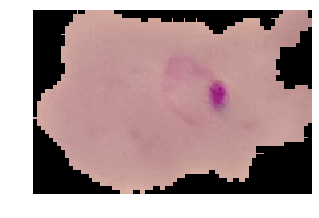

In [28]:
images_para = open_image(parasitized_images[np.random.randint(0, 9)])
images_para.show(figsize=(5,5))
images_para.size

In [29]:
uninfected_images = get_image_files(path_image_uninfected)[:10]
uninfected_images

[PosixPath('../input/cell_images/cell_images/Uninfected/C39P4thinF_original_IMG_20150622_110435_cell_41.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C61P22N_ThinF_IMG_20150818_112626_cell_54.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C124P85ThinF_IMG_20151002_154846_cell_133.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C129P90ThinF_IMG_20151004_134520_cell_60.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C177P138NThinF_IMG_20151201_141604_cell_152.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C164P125ThinF_IMG_20151116_113954_cell_98.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C164P125ThinF_IMG_20151116_113651_cell_117.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C116P77ThinF_IMG_20150930_171844_cell_14.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C129P90ThinF_IMG_20151004_133921_cell_25.png'),
 PosixPath('../input/cell_images/cell_images/Unin

In [30]:
path_unin, dirs, files = next(os.walk(path_image_uninfected))
file_count = len(files)
print("Number of images for uninfected:", file_count)

Number of images for uninfected: 13780


torch.Size([136, 151])

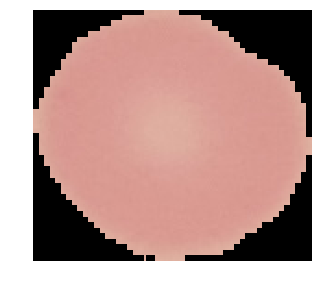

In [31]:
images_unin = open_image(uninfected_images[np.random.randint(0, 9)])
images_unin.show(figsize=(5,5))
images_unin.size

## Observations: 
- Data is evenly balanced in number of images for uninfected and infected
- Images aren't evenly sized.
- I assume purple cells are white blood cells and peach are red blood cells
- Not positive on what ThinF means. I assume it means thin slices of cells
- Unsure what the various versions of ReThinF, NThinF, ThinF, thinF, etc. denotes in the images


# Data Bunching
<input type="checkbox"> Combine uninfected & infected for training set
<input type="checkbox"> Resize images to uniform size


In [32]:
path

PosixPath('../input/cell_images/cell_images')

In [33]:
data = ImageDataBunch.from_folder(path, train=".",
                                  valid_pct=0.2, # Splits the dataset into 80/20% training/validation
                                  ds_tfms=get_transforms(do_flip = True, flip_vert = True, max_warp=0), # AFAIK images can be flipped any direction vertically, horizontally, 90 degrees in actual cell images
                                  size=224,bs=64 # Trying out a larger 256 size at first
                                 ).normalize(imagenet_stats)

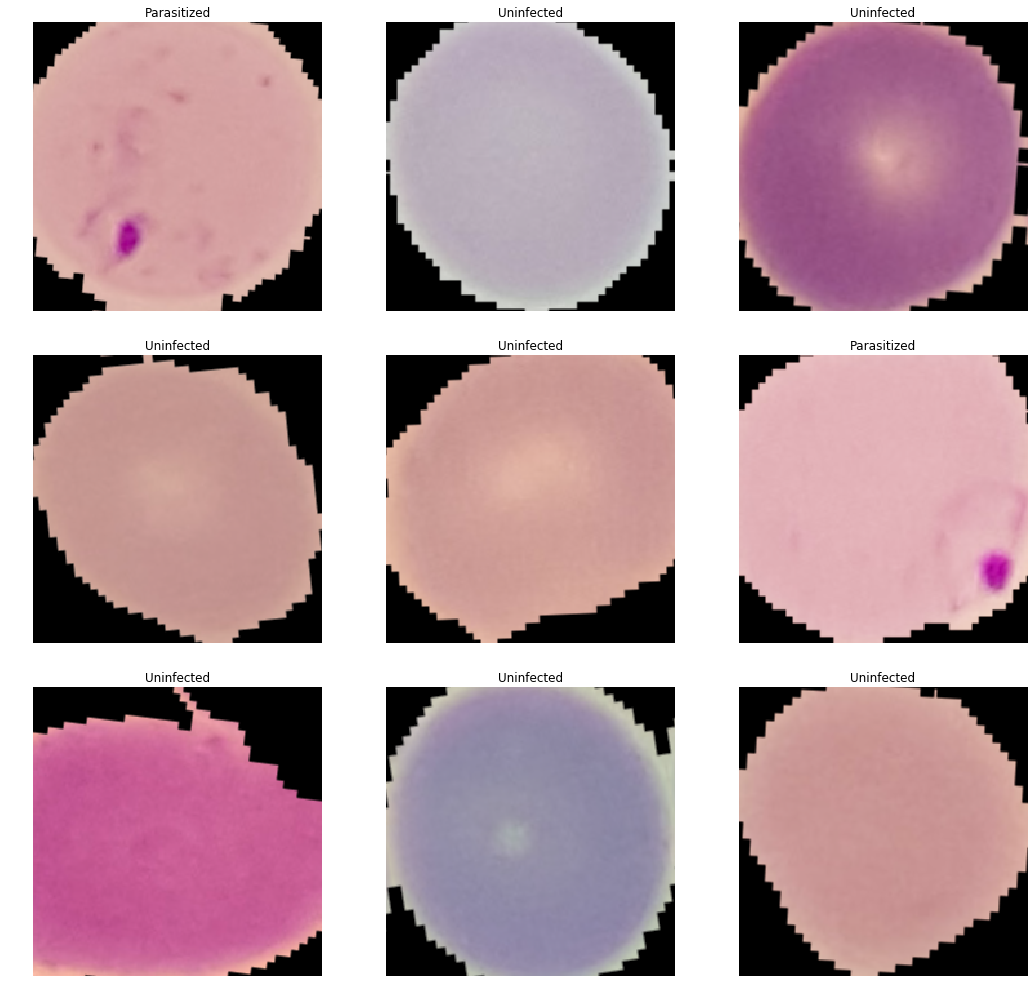

In [34]:
data.show_batch(rows=3, figsize=(15,14))

In [35]:
print(data.classes)
len(data.classes),data.c

['Parasitized', 'Uninfected']


(2, 2)

# Model Training

In [36]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, model_dir="/kaggle/model")

In [37]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [38]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.216994,0.147700,0.055525,03:22
1,0.169434,0.121874,0.041735,03:02
2,0.144129,0.110297,0.038650,03:01
3,0.131473,0.109775,0.038106,02:59


In [39]:
learn.save('malaria_initial_training')

# Examining results of initial training

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

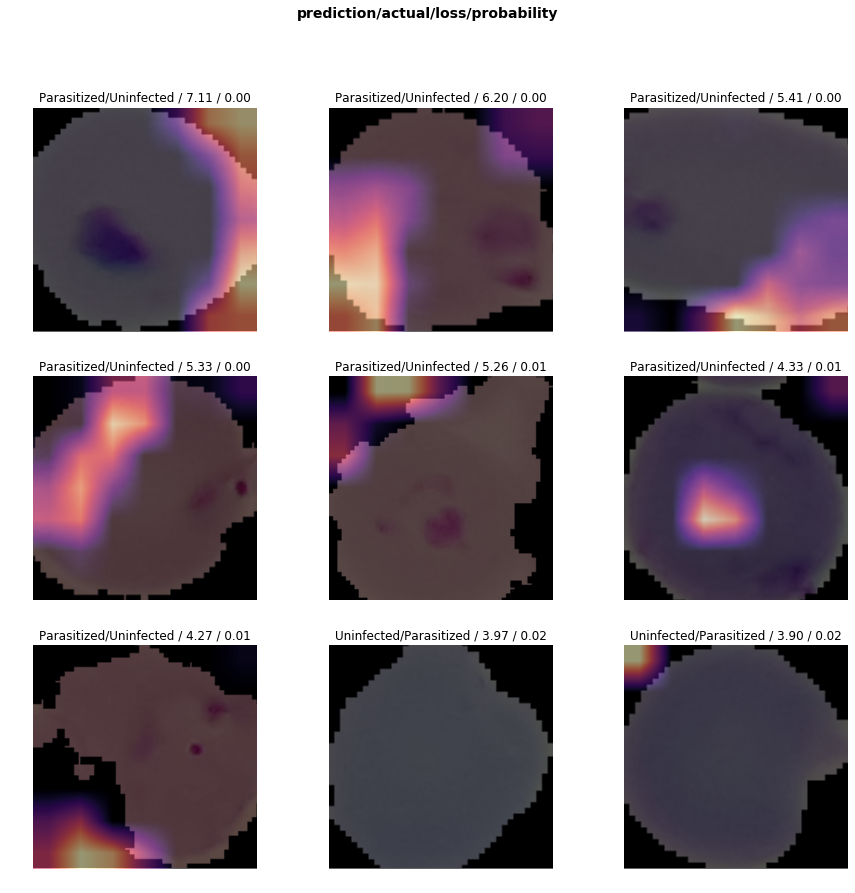

In [41]:
# Note: these are images that are in the top_losses section. Model was not sure what these were 
# TODO: Ask someone with biology background to predict these
interp.plot_top_losses(9, figsize=(15,14))

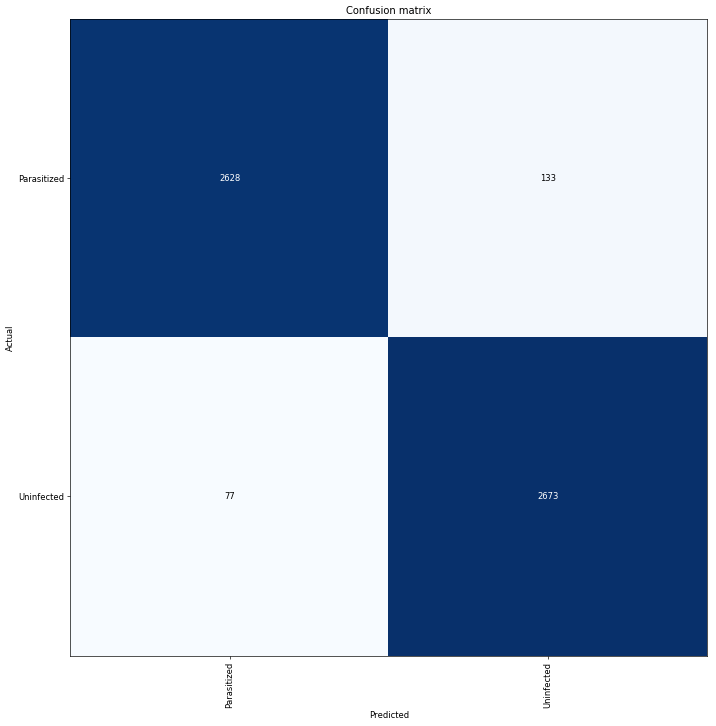

In [42]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Model improvement
<input type="checkbox"> Unfreeze layer 1. All the information gleamed off resnet34 to form basic shapes as I understand it.
<input type="checkbox"> Fine tune learning rate

In [43]:
learn.unfreeze()

In [45]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.131808,0.095279,0.035202,03:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


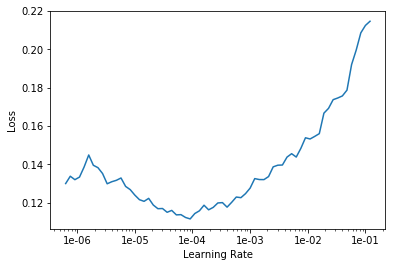

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.110145,0.083273,0.031029,03:01
1,0.098727,0.080293,0.031029,02:59


# Reexamining results
Improvement! 🙌

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

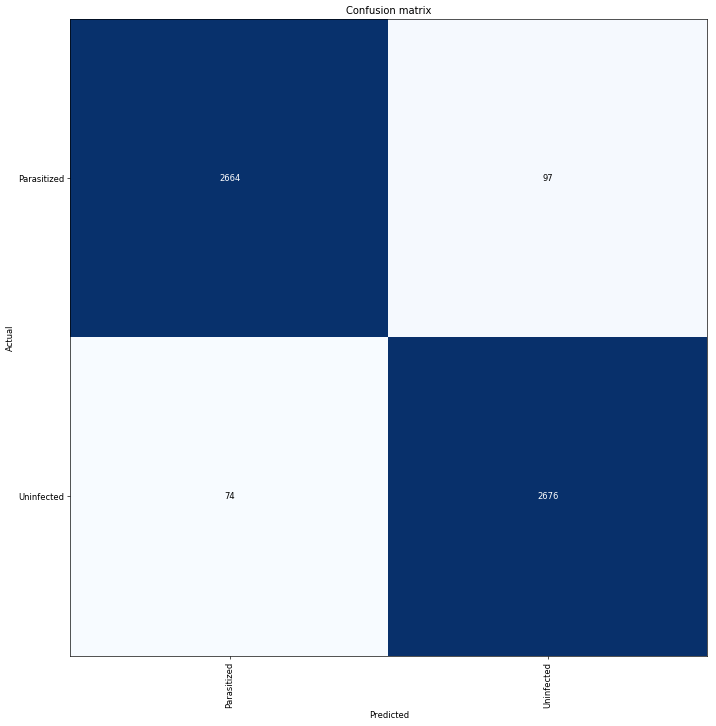

In [49]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [50]:
learn.save('malaria_unfrozen_and_tuned')

# But 97% accuracy is probably too low for medical diagnosis. I'm guessing they want 99.9% or higher
> <input type="checkbox"> ResNet50

In [ ]:
# learn.load('malaria_unfrozen_and_tuned')

In [58]:
data = ImageDataBunch.from_folder(path, train=".",
                                  valid_pct=0.2, # Splits the dataset into 80/20% training/validation
                                  ds_tfms=get_transforms(flip_vert = True), # AFAIK images can be flipped any direction vertically, horizontally, 90 degrees in actual cell images
                                  size=299,bs=32
                                 ).normalize(imagenet_stats)

In [59]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, model_dir="/kaggle/model")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


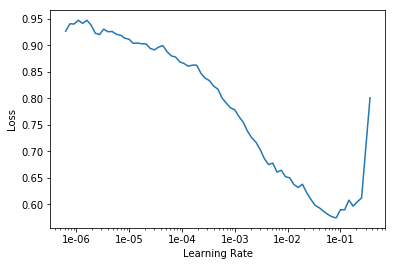

In [60]:
learn.lr_find()
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(8, 3e-3)
# https://youtu.be/ccMHJeQU4Qw?t=3552 ¯\_(ツ)_/¯

epoch,train_loss,valid_loss,error_rate,time
0,0.173753,0.126507,0.040646,05:57
1,0.163899,0.131506,0.046090,05:56
2,0.154564,0.112745,0.039013,05:57
3,0.140702,0.100300,0.034295,05:49
4,0.122497,0.124691,0.037924,05:47
5,0.098470,0.081026,0.028851,05:46
6,0.091114,0.076028,0.027763,05:46
7,0.090107,0.075958,0.028126,05:47


In [62]:
learn.save('/kaggle/working/malaria_initial_training_resnet50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


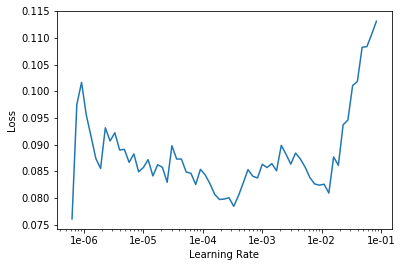

In [63]:
learn.lr_find()
learn.recorder.plot()

In [64]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.085482,0.076157,0.028488,06:22
1,0.086071,0.074951,0.027400,06:12
2,0.088901,0.074919,0.026492,06:10


In [65]:
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.087971,0.076840,0.027037,06:11
1,0.090470,0.073852,0.027218,06:10
2,0.074357,0.072449,0.026492,06:06


In [66]:
#TODO: Figure out how many epochs before this starts doing badly. Just starting to get good! Could push a couple more.
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.067793,0.073612,0.025948,06:14


In [69]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

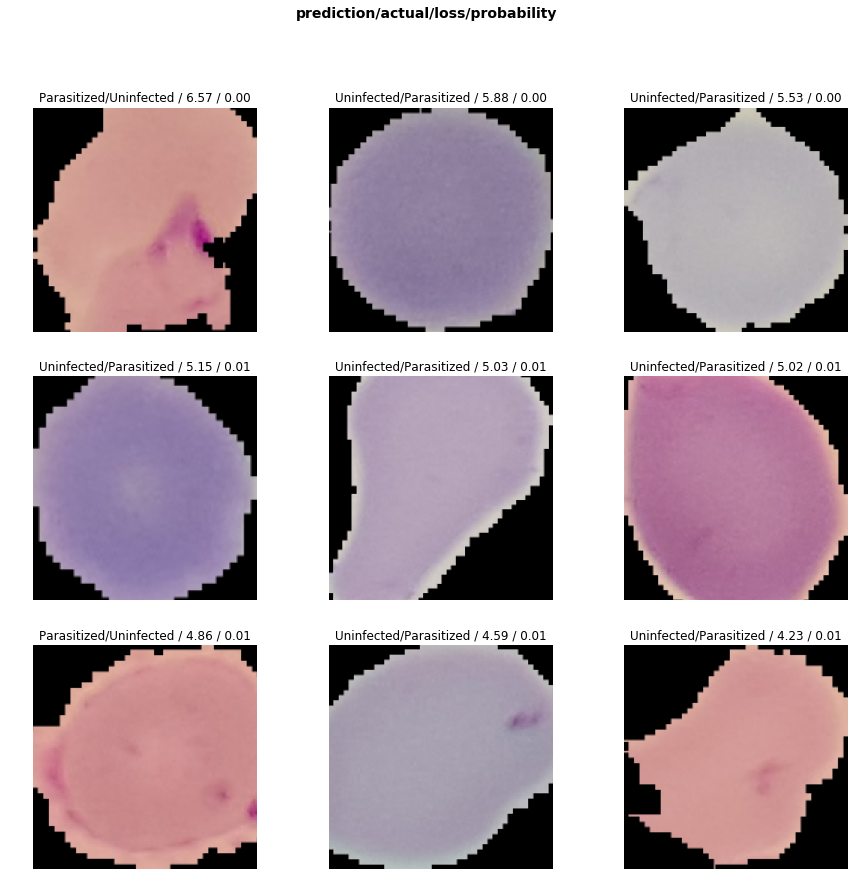

In [70]:
interp.plot_top_losses(9, figsize=(15,14), heatmap = False)

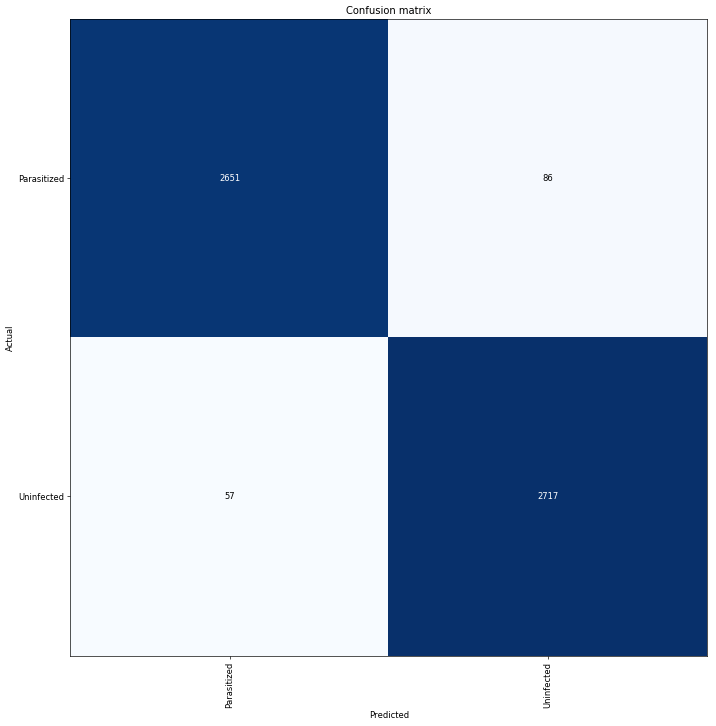

In [71]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)